# WeLoveDogs

In [1]:
# import all modules required
import pandas as pd
import numpy as np
import requests
import json
import tweepy
import timeit
from bs4 import BeautifulSoup
import re
import os

## Gather

### Enhanced Data (Manual Download)

In [62]:
df_enhanced = pd.read_csv('twitter_archive_enhanced.csv')

### Image Predictions (Programatic Download)

In [3]:
predictions_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

In [4]:
response = requests.get(predictions_url)

In [5]:
with open('image_predictions.tsv', mode = 'wb') as file:
    file.write(response.content)

In [6]:
df_predict = pd.read_csv('image_predictions.tsv', '\t')

In [7]:
df_predict.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [8]:
df_enhanced.shape

(2356, 17)

### Additional Information (Twitter API)

#### Authenticate

In [9]:
# import consumer token/secret from file for authentication
with open('twitter_credentials.txt', encoding = 'utf-8') as file:
    api_key = file.readline()[:-1]
    api_secret_key = file.readline()[:-1]
    access_token = file.readline()[:-1]
    access_token_secret = file.readline()

In [10]:
# authenticate
auth = tweepy.OAuthHandler(api_key, api_secret_key)
auth.set_access_token(access_token, access_token_secret)

In [11]:
# define api
api = tweepy.API(auth)

#### Retrieve Tweet JSON and Export txt

In [12]:
# http://docs.tweepy.org/en/v3.2.0/api.html#status-methods
# https://stackabuse.com/reading-and-writing-json-to-a-file-in-python

# 
tweepy.api.wait_on_rate_limit = True
tweepy.api.wait_on_rate_limit_notify = True

# create list of tweets to query the API
tweet_id_list = df_enhanced['tweet_id'].tolist()

# Start Timer
start = timeit.timeit()

file_name = 'tweet_json.txt'

# if file exists create file else skip this step
if not os.path.exists(file_name):
    # Open tweet_json.txt with file hander
    with open(file_name, mode = 'wt') as file:

        # loop through tweet_id list and write tweet JSON to txt
        for tweet_id in tweet_id_list:
            try:
                tweet = api.get_status(tweet_id)
                json_str = json.dumps(tweet._json)
                json_str += '\n'
                file.write(json_str)
            except:
                json_str = '{}'
                json_str += '\n'
                file.write(json_str)

# End Timer
end = timeit.timeit()
print(end - start)

0.0033167650000009985


#### Import Twitter from txt

In [13]:
additional_list = []

# https://stackoverflow.com/questions/15599639/what-is-the-perfect-counterpart-in-python-for-while-not-eof

with open('tweet_json.txt', encoding = 'utf-8') as openfileobject:
    for line in openfileobject:
        try:
            data = json.loads(line)
            tweet_id = data['id']
            favorite_count = data['favorite_count']
            retweet_count = data['retweet_count']
            additional_list.append({'tweet_id':tweet_id,
                                    'favorite_count':favorite_count,
                                    'retweet_count':retweet_count})
        except:
            tweet_id = np.NaN
            favorite_count = np.NaN
            retweet_count = np.NaN
            additional_list.append({'tweet_id':tweet_id,
                                    'favorite_count':favorite_count,
                                    'retweet_count':retweet_count})

df_additional = pd.DataFrame(additional_list)

In [14]:
# check all tweet IDs from enhanced were gathered into additional
assert(df_additional.shape[0] == df_enhanced.shape[0])

## Assess

<b> NOTE: </b> assessments made using cells below and visual assessments made in google sheets

<b>Tidiness</b>

each variable forms a column

    1. Enhanced
        * none
    2. Predict:
        * source url and source type contained in one column 'source'
    3. Additional
        * none


each observation forms a row

    1. Enhanced
        * none
    2. Predict
        * none
    3. Additional
        * none


each type of observational unit forms a table

    1. enhanced, additional and predict should be contined within one dataFrame



<b>Quality</b>

Completness

    1. Enhanced
        * dataframe contains 181 re-tweets. we wish only to look at original tweets.
    2. Predict
        * none
    3. Additional
        * none

Validity

    1. Enhanced
        * not all rating denominators are equal to 10. scoring system is out of 10.
    2. Predict
        * none
    3. Additional
        * none

Accuracy

    1. Enhanced
        * groups of dogs rated - remove / replace with divisor rating and indicator column isGroup
        * the original cleaning attempt has not correctly handled non integer ratings e.g. 9.75 / 10 has rating numerator 75 / 10 for tweet ID 722974582966214656
        * original data cleaning has picked up other numerial data as rating. e.g. tweet 740373189193256964 contains '9/11' as to mean 11th September. numerator / denominator returned as 9 / 11 resp.
        * tweet_id does not contain a rating 810984652412424192. contains '24/7' to mean 24 hours and 7 days which is being picked up as the numerator and denominator. tweet_id does not contain a rating.
        * tweet_id 670842764863651840 and 749981277374128128 numerators form a joke but skew numerator data
    2. Predict
        * none
    3. Additional
        * none

Consistency

    1. Enhanced
        * timestamp recorded as string not date time
        * doggo, floofer, pupper, puppo -- should be True/False
    2. Predict
        * format of p1, p2, p3 is inconsistent: mixture of upper and lower case, mixture of '_', '-' and ' '
    3. Additional
        * none


In [15]:
df_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [16]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [17]:
df_additional.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 3 columns):
favorite_count    1994 non-null float64
retweet_count     1994 non-null float64
tweet_id          1994 non-null float64
dtypes: float64(3)
memory usage: 55.3 KB


In [18]:
df_enhanced.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
557,803380650405482500,NaN,NaN,2016-11-28 23:30:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sonny. He's an in-home movie critic. That...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/803380650...,12,10,Sonny,None,None,None,None
1557,688804835492233216,NaN,NaN,2016-01-17 19:27:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you stumble but recover quickly cause you...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/688804835...,12,10,None,None,None,None,None
2195,668872652652679168,NaN,NaN,2015-11-23 19:24:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Amélie. She is a confident white colle...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668872652...,11,10,Amélie,None,None,None,None
923,755955933503782912,NaN,NaN,2016-07-21 02:41:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a frustrated pupper attempting to escap...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/755955933...,12,10,None,None,None,pupper,None
1194,717428917016076293,NaN,NaN,2016-04-05 19:09:17 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Skittle. He's trying to communicate. 1...,NaN,NaN,NaN,https://vine.co/v/iIhEU2lVqxz,11,10,Skittle,None,None,None,None


In [19]:
df_predict.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1759,825829644528148480,https://pbs.twimg.com/media/C3XvqILXUAU2nnT.jpg,2,Great_Pyrenees,0.853407,True,golden_retriever,0.053531,True,English_setter,0.045830,True
532,676864501615042560,https://pbs.twimg.com/media/CWS0q8iU8AE2Srr.jpg,1,Chesapeake_Bay_retriever,0.371146,True,water_buffalo,0.099596,False,Weimaraner,0.048968,True
1541,791026214425268224,https://pbs.twimg.com/media/CpmyNumW8AAAJGj.jpg,1,malamute,0.375098,True,jean,0.069362,False,keeshond,0.050528,True
1363,761334018830917632,https://pbs.twimg.com/media/CpDNQGkWEAENiYZ.jpg,1,Norwegian_elkhound,0.822936,True,malinois,0.086152,True,German_shepherd,0.063333,True
189,669375718304980992,https://pbs.twimg.com/media/CUoZqaqWcAAA2MQ.jpg,1,Airedale,0.168762,True,Norfolk_terrier,0.107479,True,Lakeland_terrier,0.097846,True


In [20]:
df_additional.sample(5)

,favorite_count,retweet_count,tweet_id
1062,10362.0,5834.0,7.410998e+17
1197,3356.0,1019.0,7.170094e+17
171,0.0,8178.0,8.588604e+17
1965,2519.0,1293.0,6.733456e+17
1799,2798.0,964.0,6.771873e+17


In [21]:
# dataType of timestamp
type(df_enhanced['timestamp'][0])

str

In [22]:
# source columns unique entries
df_enhanced['source'].unique().tolist()

['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
 '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
 '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>']

In [24]:
# check formating of sample of dog breeds
df_predict[['p1','p2','p3']].sample(5)

,p1,p2,p3
928,golden_retriever,Chesapeake_Bay_retriever,Brittany_spaniel
1725,school_bus,cab,crane
1896,tennis_ball,kelpie,malinois
2028,Pembroke,Chihuahua,Cardigan
559,Siberian_husky,junco,malamute


In [25]:
# number of rating denominators not equal to 10
(df_enhanced['rating_denominator'] != 10).sum()

23

In [26]:
# number of rating numerators less than ten greater than 20
(df_enhanced['rating_numerator'] > 20).sum()

24

##### Accuracy/Validity issues spotted looking at 23/19 examples that dont meet requirements in two cells above

###### No Rating Provided:
810984652412424192: no rating provided but picking up a date rather than a rating

###### Numerator unrealistic (forms part of a joke):
670842764863651840,
749981277374128128

###### Groups of Dogs:
820690176645140481,
758467244762497024,
731156023742988288

###### Original Cleaning Picked Up a Date/Other Rather Than Rating:
740373189193256964,
722974582966214656

###### Original Cleaning did not pick up float as numerator:
680494726643068929

## Clean

In [27]:
df_enhanced_clean = df_enhanced.copy()
df_predict_clean = df_predict.copy()
df_additional_clean = df_additional.copy()

### Quality

#### Cleaning for Copmleteness

##### Define

Convert tweetIDs from enhanced and predict dataFrame into lists and use sets to find the missing tweetIDs. From here run the missing tweet IDs through the predict algorithm and add to predict dataFrame // remove the missing tweetIDs from the enhanced dataFrame.

##### Code

In [28]:
df_enhanced_clean = df_enhanced_clean[df_enhanced_clean['tweet_id'].isin(df_predict_clean['tweet_id'])]

##### Test

In [29]:
# list of missing tweet IDs
missing_tweetIDs = list(set(df_enhanced_clean['tweet_id'].to_list()) - set(df_predict['tweet_id'].to_list()))

# check that the length of missing tweetIDs is now zero
assert(len(missing_tweetIDs) == 0)

##### Define

Remove re-tweets by filtering out all rows with retweet ID not equal to NaN

##### Code

In [30]:
df_enhanced_clean = df_enhanced_clean[df_enhanced_clean['retweeted_status_id'].isna()]

##### Test

In [31]:
assert(df_enhanced_clean['retweeted_status_id'].notna().sum() == 0)

### Tidiness

#### Each Observational Unit Forms a Table

##### Define

* Use pandas merge function to create master data frame combining df_enhanced and df_additional to create df_master_temp (and test)
* Use pandas merge function to create master data frame combining df_master_temp and df_predict to create df_master (and test)

<b> NOTE: </b> done in this order to test each merge sequentially

##### Code

In [32]:
df_master_clean_temp = df_enhanced_clean.merge(df_additional_clean, 
                                               how = 'left', left_on = 'tweet_id', right_on = 'tweet_id')

##### Test

In [33]:
def test_merge(merge_column, df_1, df_2, df_merged):
    try:
        
        # check randomly select column from df_1 exists in df_merged
        random_col_df = np.random.choice(list(set(df_1.columns.tolist()) - set([merge_column])))
        df_merged[random_col_df]
        
        # check randomly select column from df_2 exists in df_merged
        random_col_df = np.random.choice(list(set(df_2.columns.tolist()) - set([merge_column])))
        df_merged[random_col_df]
        
        # return 1 for assert statement (pass)
        return 1     
    
    except:
        
        # return 0 for assert statement (fail)
        return 0

# assert merge passed test_merge
assert(test_merge('tweet_id', df_enhanced_clean, df_additional_clean ,df_master_clean_temp) == 1)


##### Code

In [34]:
df_master_clean = df_master_clean_temp.merge(df_predict_clean,
                                             how = 'left', left_on = 'tweet_id', right_on = 'tweet_id')

##### Test

In [35]:
assert(test_merge('tweet_id', df_master_clean_temp, df_predict_clean ,df_master_clean) == 1)

In [36]:
assert(df_master_clean.shape[0] == df_enhanced_clean.shape[0])

#### Each Variable Forms a Column

##### Define

Loop through each entry in the dataFrame.
Using beautiful soup strip source_type and source_url from the html tag.
Append to list of dictionaries
Update existing dataFrame with new columns
Drop original source column

##### Code

In [37]:
# https://www.geeksforgeeks.org/python-check-url-string/

def Find_URL(string): 
    # findall() has been used  
    # with valid conditions for urls in string 
    url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', string) 
    return url


In [38]:
source_list = df_master_clean['source'].tolist()
df_list = []

for source in source_list:
    soup = BeautifulSoup(source, "lxml")
    source_description = soup.find('a').contents[0]
    source_url = Find_URL(source)[0]
    df_list.append({'source_type':source_description, 'source_url':source_url})
    
df_master_clean[['source_type','source_url']] = pd.DataFrame(df_list)
df_master_clean.drop('source', axis = 1, inplace = True)

##### Test

In [39]:
df_master_clean[['source_type','source_url']].sample(5)

,source_type,source_url
1136,Twitter for iPhone,http://twitter.com/download/iphone
1138,Twitter for iPhone,http://twitter.com/download/iphone
1324,Twitter for iPhone,http://twitter.com/download/iphone
1081,Twitter for iPhone,http://twitter.com/download/iphone
1885,Twitter for iPhone,http://twitter.com/download/iphone


### Quality

#### Cleaning for Validity and Accuracy

##### Define

Remove tweet_id 670842764863651840, 749981277374128128, 810984652412424192

##### Code

In [40]:
remove_list = [670842764863651840, 749981277374128128, 810984652412424192]
df_master_clean = df_master_clean[~df_master_clean['tweet_id'].isin(remove_list)]

##### Test

In [41]:
assert((df_master_clean['tweet_id'] == 81098465241242419).sum() == 0)

##### Define

* use regular expressions to identify ratings including numerators containing decimals
* typically ratings occur at end of tweet so if tweet cointains multiple numerical data prioritise end numerical data / numerator with proceeding /10 denominator.
* sense check results against pre-determined tweet IDs
* replace existing numerators column with new numerators column

##### Code

In [42]:
def find_rating(string): 
    # gather all fractions
    rating = re.findall('[0-9]+\.?[0-9]*/[0-9]+', string) 
    
    # when multiple fractions in string take last fraction
    rating = rating[len(rating)-1]
    
    # 
    rating_split = re.findall('[0-9]+\.?[0-9]*', rating)
    numerator = rating_split[0]
    denominator = rating_split[1]   
    
    return (float(numerator), float(denominator))

In [43]:
df_master_clean['rating_numerator'] = df_master_clean['text'].apply(lambda x: find_rating(x)[0])
df_master_clean['rating_denominator'] = df_master_clean['text'].apply(lambda x: find_rating(x)[1])

##### Test

In [44]:
# unit test
assert(df_master_clean['rating_numerator'][df_master_clean['tweet_id'] == 740373189193256964].tolist()[0] == 14)
assert(df_master_clean['rating_numerator'][df_master_clean['tweet_id'] == 722974582966214656].tolist()[0] == 13)

##### Define
* when groups of dogs rated add a boolean column called isGroup
* work out the number of animals in the group rated by dividing the numerator by 10 (as each dog in group is rated out of 10)
* work out the average numerator by dividing the total numerator by number of dogs in the group
* set rating denominator to 10
* drop temporary num_animals columns

##### Code

In [45]:
# code below works for non groups as num_animals returns 1 thus denominator and numerator not effected
df_master_clean['isGroup'] = df_master_clean['rating_denominator'] != 10
df_master_clean['num_animals'] = df_master_clean['rating_denominator'] / 10
df_master_clean['rating_numerator'] = df_master_clean['rating_numerator'] / df_master_clean['num_animals']
df_master_clean['rating_denominator'] = 10.0
df_master_clean.drop('num_animals', axis = 1, inplace = True)

##### Test

In [46]:
assert(df_master_clean['rating_numerator'][df_master_clean['rating_numerator'] > 20].sum() == 0)
assert(df_master_clean['rating_denominator'][df_master_clean['rating_denominator'] != 10].sum() == 0)

#### Cleaning for Consistency

##### Define

* Replace entry in column with either True or False if the row meets the requirement. Use df.replace function.

##### Code

In [47]:
df_master_clean[['doggo','floofer','pupper','puppo']] = df_master_clean[
    ['doggo','floofer','pupper','puppo']].replace(to_replace = ['None','doggo','floofer','pupper','puppo'],
                                                                value = [False, True, True, True, True])

In [48]:
df_master_clean[['doggo','floofer','pupper','puppo']].sample(5)

,doggo,floofer,pupper,puppo
390,False,False,False,False
908,False,False,False,False
405,False,False,False,False
97,False,False,False,False
1015,False,False,True,False


##### Test

In [49]:
assert((df_master_clean[['doggo','floofer','pupper','puppo']] > 2).sum().sum() == 0)

##### Define

* Required format spec: all letters lower case, all spaces represented by '_'
* Use .str.replace to achieve this

##### Code

In [50]:
columns = ['p1','p2','p3']
for col in columns:
    df_master_clean[col] = df_master_clean[col].str.lower()
    df_master_clean[col] = df_master_clean[col].str.replace('-','_')
    df_master_clean[col] = df_master_clean[col].str.replace(' ','_')

df_predict_clean[columns];

##### Test

In [51]:
for col in columns:
    assert(df_master_clean[col].str.count(' ').sum() == 0)
    assert(df_master_clean[col].str.count('-').sum() == 0)

##### Define
Convert timestamp column in df_master_clean to datetime using pandas to_datetime function. 

##### Code

In [52]:
df_master_clean['timestamp'] = pd.to_datetime(df_master_clean['timestamp'].str[:-6])

##### Test

In [53]:
assert(type(df_master_clean['timestamp'][0]) == pd._libs.tslibs.timestamps.Timestamp)

## Export

In [54]:
df_master_clean.to_csv('twitter_archive_master.csv')

## Visualize

All data has been assessed and cleaned (above) before visualisations were produced.

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

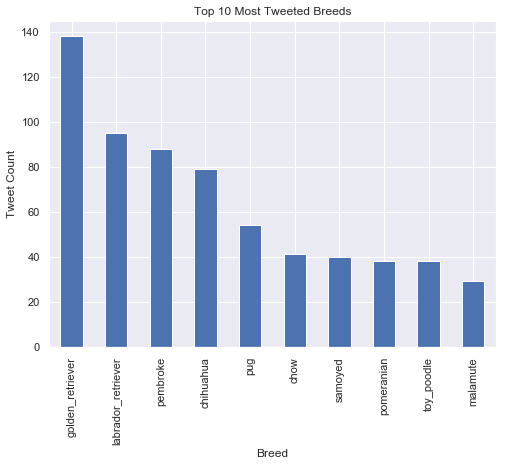

In [56]:
p1_top_10 = df_master_clean[df_master_clean['p1_dog'] == True]['p1'].value_counts()
p1_top_10.nlargest(10).plot(kind = 'bar', title='Top 10 Most Tweeted Breeds', figsize = (8,6));
plt.xlabel('Breed');
plt.ylabel('Tweet Count');


In [57]:
p1_retweet_mean = df_master_clean[df_master_clean['p1_dog'] == True][['p1','retweet_count']].groupby('p1').mean()
p1_retweet_count = df_master_clean[df_master_clean['p1_dog'] == True][['p1','p2']].groupby('p1').count()

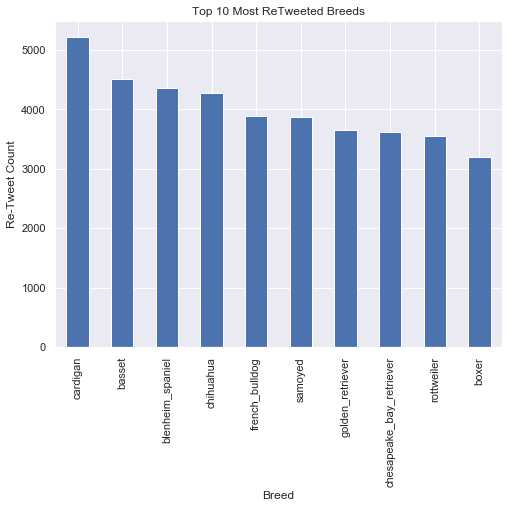

In [58]:
p1_retweet = p1_retweet_mean.merge(p1_retweet_count, left_on = 'p1', right_on = 'p1')
p1_retweet = p1_retweet[p1_retweet['p2'] >= 10]['retweet_count']
p1_retweet_top10 = p1_retweet.nlargest(10)
p1_retweet_top10.plot(kind = 'bar',title='Top 10 Most ReTweeted Breeds', figsize = (8,6));
plt.xlabel('Breed');
plt.ylabel('Re-Tweet Count');

In [59]:
df_master_clean['p1_dog'].value_counts()[True]/df_master_clean.shape[0]

0.7413360120542442

In [60]:
(df_master_clean['rating_numerator'][df_master_clean['p1_dog'] == False] >= 10).sum() / (df_master_clean['p1_dog'] == False).sum()

0.629126213592233

In [61]:
(df_master_clean['rating_numerator']>=10).sum() / df_master_clean.shape[0]

0.789552988448016

## Insights

All data has been assessed and cleaned (above) before insights were drawn.

* Only 75% of tweets rated by WeRateDogs are actually dogs, according to the Neural Network predicting breed. This statement assumes the accuracy of the Neural Network.
* Although undefined, the rating scale runs from 0/10 - 13/10
* 80% of tweets on we rate dogs recieve a 10/10 rating or higher!
* 60% of tweets that weren't even dogs recieve a 10/10 rating or higher!
* Golden retriever and labrador were the two most tweeted about breeds
* Cardigan and basset were the most retweeted breeds on average (excluding all breeds which had less than 10 postings)